In [15]:
# import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [16]:
# ====================================================================
# PART 1: LOAD IMAGES INTO ARRAYS
# ====================================================================

DATASET_PATH = DATASET_PATH = r"D:\realwaste" # Update this path to your dataset location
IMG_HEIGHT, IMG_WIDTH = 128, 128

def load_dataset(dataset_path, img_height, img_width):
    X, y = [], []
    class_names = sorted(os.listdir(dataset_path))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_dir):
            continue
        for img_file in tqdm(os.listdir(class_dir), desc=f'Loading {class_name}'):
            img_path = os.path.join(class_dir, img_file)
            try:
                img = image.load_img(img_path, target_size=(img_height, img_width))
                img_array = image.img_to_array(img) / 255.0
                X.append(img_array)
                y.append(label)
            except Exception as e:
                print(f"Skipping {img_path}: {e}")
    return np.array(X), np.array(y), class_names

X, y, class_names = load_dataset(DATASET_PATH, IMG_HEIGHT, IMG_WIDTH)
num_classes = len(class_names)
print(f"Dataset loaded: {X.shape[0]} images, {num_classes} classes")

Loading Glass:  22%|██▏       | 91/420 [00:01<00:05, 62.30it/s]


KeyboardInterrupt: 

In [ ]:
# ====================================================================
# PART 2: TRAIN-VALIDATION-TEST SPLIT (70%-15%-15%)
# ====================================================================

# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: 15% validation, 15% test (50-50 split of 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 3326
Validation samples: 713
Testing samples: 713


In [ ]:
# ====================================================================
# PART 3: BUILD THE FINE-TUNED VGG16 MODEL
# ====================================================================

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Build new model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 42s 1us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# ====================================================================
# PART 4: TRAIN THE MODEL (20 epochs)
# ====================================================================

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.5701 - loss: 1.2548 - val_accuracy: 0.5905 - val_loss: 1.2497
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.5731 - loss: 1.2409 - val_accuracy: 0.5905 - val_loss: 1.2389
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.5803 - loss: 1.2097 - val_accuracy: 0.5947 - val_loss: 1.2275
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.5887 - loss: 1.2034 - val_accuracy: 0.6045 - val_loss: 1.2156
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.5944 - loss: 1.1983 - val_accuracy: 0.5989 - val_loss: 1.2077
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.5935 - loss: 1.1798 - val_accuracy: 0.6045 - val_loss: 1.1936
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.6007 - loss: 1.1703 - val_accuracy: 0.5961 - val_loss: 1.1854
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.6013 - loss: 1.1581 - val_accu

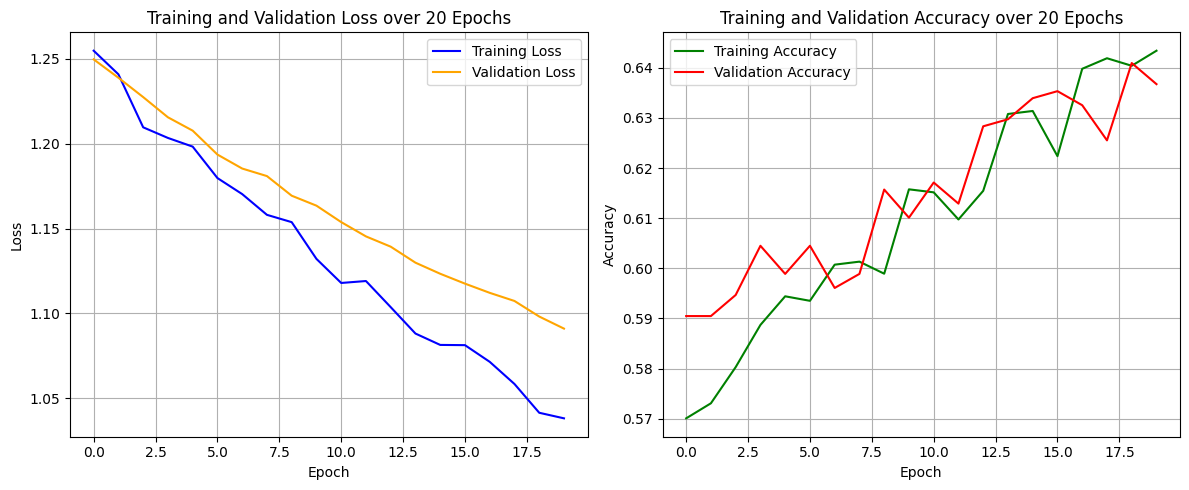

In [ ]:
# ====================================================================
# PART 5: TRAINING METRICS
# ====================================================================

# Get training metrics
train_accuracy = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]

# Create figure with 2 subplots (side by side)
plt.figure(figsize=(12, 5))

# Plot 1: Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss over 20 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy over 20 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show both plots
plt.tight_layout()
plt.show()



In [ ]:
# ====================================================================
# PART 6: EVALUATION ON TEST SET
# ====================================================================

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("\nEvaluation Results")
print(f"Train Accuracy: {train_accuracy*100:.2f}%")
print(f"Train Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step

Evaluation Results
Train Accuracy: 64.34%
Train Loss: 1.0381
Test Accuracy: 62.55%
Test Loss: 1.0698
Precision: 0.6261
Recall: 0.6173
F1-Score: 0.6147


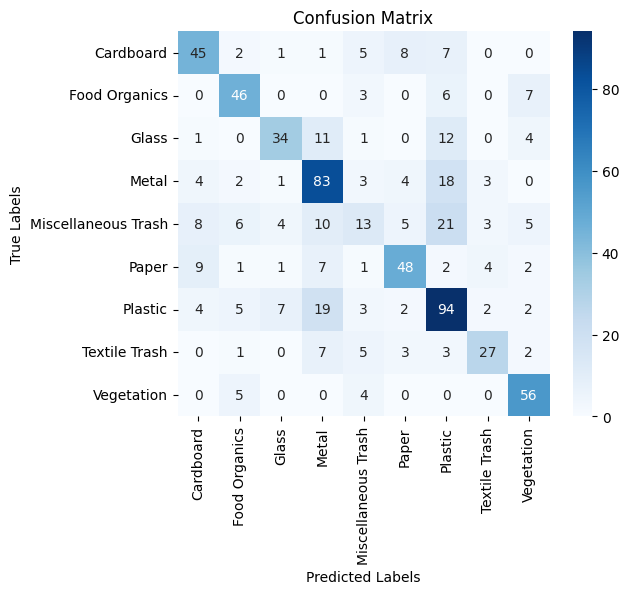


Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.63      0.65      0.64        69
      Food Organics       0.68      0.74      0.71        62
              Glass       0.71      0.54      0.61        63
              Metal       0.60      0.70      0.65       118
Miscellaneous Trash       0.34      0.17      0.23        75
              Paper       0.69      0.64      0.66        75
            Plastic       0.58      0.68      0.62       138
      Textile Trash       0.69      0.56      0.62        48
         Vegetation       0.72      0.86      0.78        65

           accuracy                           0.63       713
          macro avg       0.63      0.62      0.61       713
       weighted avg       0.61      0.63      0.61       713



In [ ]:
# ====================================================================
# PART 7: CONFUSION MATRIX & REPORT
# ====================================================================

# Ensure y_true and y_pred are numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Identify unique labels actually present in y_true
unique_labels = np.unique(y_true)
filtered_class_names = [class_names[i] for i in unique_labels]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=filtered_class_names,
            yticklabels=filtered_class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=unique_labels, target_names=filtered_class_names))